In [9]:
# read states from pkl files
import pickle
import numpy as np

# load states from several seeds
seedResStatesOriginal = []
seedResStatesShifted = []
original_seed_dir = 'data/resStatesOriginal/'
shifted_seed_dir = 'data/resStatesShifted/'

# collect all pkl files in each dir
import os
original_seed_files = os.listdir(original_seed_dir)
shifted_seed_files = os.listdir(shifted_seed_dir)

# shuffle the files
np.random.shuffle(original_seed_files)
np.random.shuffle(shifted_seed_files)
# original_seed_files.sort()
# shifted_seed_files.sort()

for file in original_seed_files:
    seedResStatesOriginal.append(pickle.load(open(original_seed_dir + file, 'rb')))

for file in shifted_seed_files:
    seedResStatesShifted.append(pickle.load(open(shifted_seed_dir + file, 'rb')))

In [10]:
# now calculate time constant (time for state to hit 1/2 of its max/initial value)
# begin/end reger to subset of states that has the different-to-same shift
from resUtils import nonzero_densities

all_timeconstants = []

for seed in range(len(seedResStatesOriginal)):

    statesOriginal = seedResStatesOriginal[seed]
    statesShifted = seedResStatesShifted[seed]
    
    timeconstants_per_network = {network: None for network in statesOriginal}

    for network in statesOriginal:
        # resn = numNode
        # index = 0
        begin=433
        end=683
        data = statesOriginal[network][begin:end,:] - statesShifted[network][begin:end,:]
        # print(data.shape)
        dataT=data.T

        timeconstants = np.zeros(dataT.shape[0])
        res_maxes = np.zeros(dataT.shape[0])

        #calculate the alignment time:  dataT(neurons,time)
        #interate over reservoir neuron
        for neuron in range(dataT.shape[0]):
            # get the value
            max = abs(dataT[neuron,0])
            if max > -1:  #WAS 0.05
                for timestep in range(dataT.shape[1]):
                    if abs(dataT[neuron,timestep]) < max/2:
                        timeconstants[neuron] = timestep
                        res_maxes[neuron] = max
                        max=-1     
                        
        save_timeconstants = timeconstants
        # normalize by the density of the network as they did in Suarez et al. 2024
        network_density = nonzero_densities[network]
        save_timeconstants_norm = save_timeconstants / network_density
        # timeconstants = np.sort(save_timeconstants)

        timeconstants_per_network[network] = save_timeconstants_norm

    all_timeconstants.append(timeconstants_per_network)

In [10]:
# now calculate the average time constant for each network across all seeds

average_timeconstants = {network: None for network in statesOriginal}

for network in statesOriginal:

    timeconstants = np.zeros(len(all_timeconstants[0][network]))

    for seed in range(len(all_timeconstants)):
        timeconstants += all_timeconstants[seed][network]

    timeconstants /= len(all_timeconstants)

    average_timeconstants[network] = timeconstants

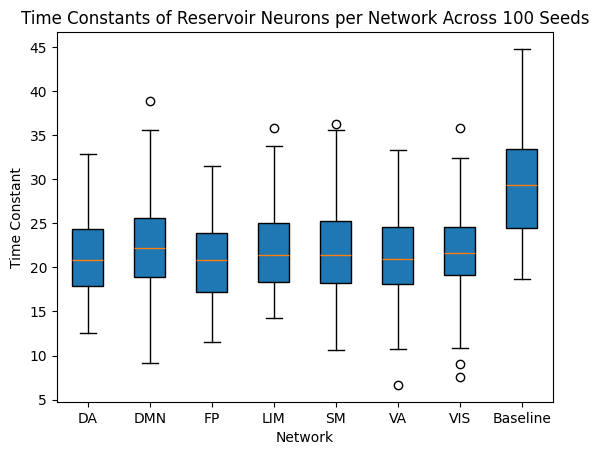

In [11]:
# now we can plot them as multiple boxplots

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.boxplot([average_timeconstants[network] for network in statesOriginal], patch_artist=True, vert=True)

ax.set_xticklabels(statesOriginal.keys())
ax.set_ylabel('Time Constant')
ax.set_xlabel('Network')
# ax.set_ylim(0,40)
plt.title('Time Constants of Reservoir Neurons per Network Across {} Seeds'.format(len(seedResStatesOriginal)))
plt.show()

Text(0.5, 1.0, 'Average Pairwise Difference in Time Constants Between Networks Across 400 Seeds')

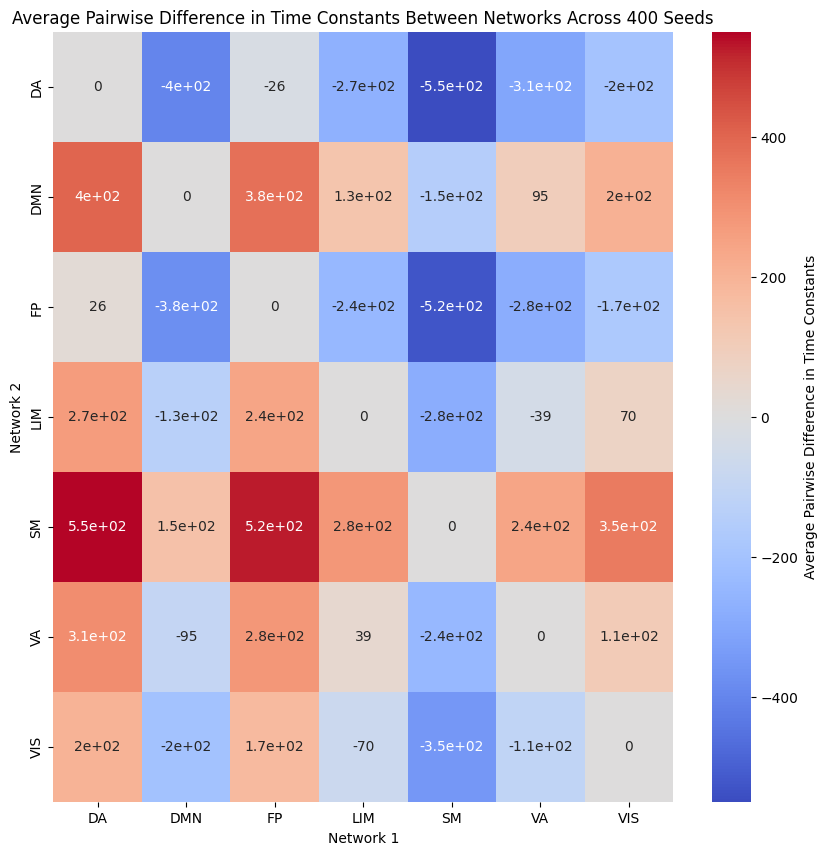

In [ ]:
# instead of looking at individual time constants, we'll look at pairwise differences between networks
diffs = {}
for seed in all_timeconstants: # for each seed
    for network1 in statesOriginal:
        for network2 in statesOriginal:
            if (network1 != 'Baseline') and (network2 != 'Baseline'):
                diffs[(network1,network2)] = []
                diffs[(network1,network2)].append((np.mean(seed[network1]) - np.mean(seed[network2])))

# now we should have a pairwise difference between networks of the absolute difference in node-wise time constants for each seed
# now we can calculate the average difference between networks across all seeds
for network1,network2 in diffs:
    diffs[(network1,network2)] = np.mean(diffs[(network1,network2)])

# now we can plot them as a heatmap
import seaborn as sns
import pandas as pd

keysNoBaseline = [key for key in statesOriginal.keys() if key != 'Baseline']

diffs_df = pd.DataFrame(index=keysNoBaseline, columns=keysNoBaseline)
for network1 in statesOriginal:
    for network2 in statesOriginal:
        if (network1 != 'Baseline') and (network2 != 'Baseline'):
            diffs_df.loc[network1,network2] = diffs[(network1,network2)]

import matplotlib.pyplot as plt
# plot the dataframe as a heatmap
plt.figure(figsize=(10,10))
sns.heatmap(diffs_df.astype(float), annot=True, cmap='coolwarm', cbar_kws={'label': 'Average Pairwise Difference in Time Constants'})
plt.xlabel('Network 1')
plt.ylabel('Network 2')
plt.title('Average Pairwise Difference in Time Constants Between Networks Across {} Seeds'.format(len(seedResStatesOriginal)))

In [12]:
# set 0 to NaN
diffs_df = diffs_df.replace(0, np.nan)

/tmp/ipykernel_3201225/3240385182.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diffs_df = diffs_df.replace(0, np.nan)


In [13]:
diffs_df

,DA,DMN,FP,LIM,SM,VA,VIS
DA,NaN,-403.237697,-25.770528,-269.088273,-550.160707,-308.078267,-199.296514
DMN,403.237697,NaN,377.467169,134.149424,-146.923010,95.159430,203.941183
FP,25.770528,-377.467169,NaN,-243.317744,-524.390179,-282.307738,-173.525986
LIM,269.088273,-134.149424,243.317744,NaN,-281.072435,-38.989994,69.791758
SM,550.160707,146.923010,524.390179,281.072435,NaN,242.082441,350.864193
VA,308.078267,-95.159430,282.307738,38.989994,-242.082441,NaN,108.781752
VIS,199.296514,-203.941183,173.525986,-69.791758,-350.864193,-108.781752,NaN


/tmp/ipykernel_3201225/2531782846.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=diffs_df['mean'], y=diffs_df.index, palette='coolwarm')


Text(0.5, 1.0, 'Average Pairwise Difference in Time Constants Between Networks Across 400 Seeds')

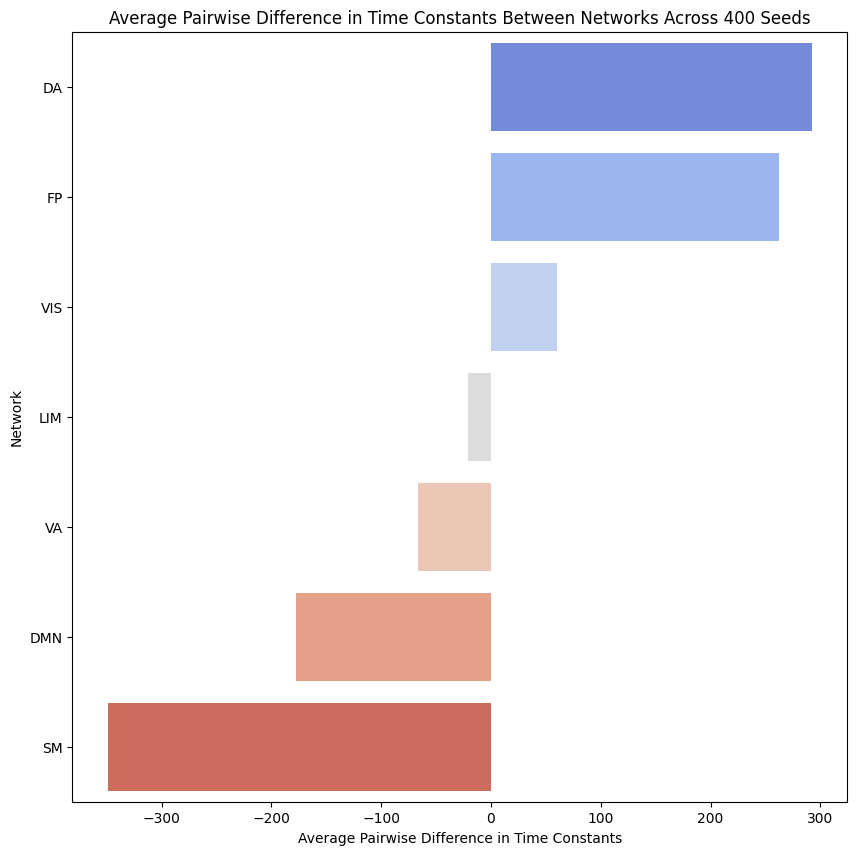

In [14]:
# order each network by the average difference in time constants, but don't include itself in the average
#diffs_df['mean'] = diffs_df[diffs_df.columns.difference([diffs_df.index.name])].mean(axis=0)
diffs_df['mean'] = diffs_df.mean(axis=0, skipna=True)
diffs_df = diffs_df.sort_values('mean', ascending=False)
# create a standard deviation column
#diffs_df['std'] = diffs_df.std(axis=0)
# bar plot
plt.figure(figsize=(10,10))
sns.barplot(x=diffs_df['mean'], y=diffs_df.index, palette='coolwarm')
# add error bars
# plt.errorbar(diffs_df['mean'], diffs_df.index, xerr=diffs_df['std'], fmt='o', color='black')
plt.xlabel('Average Pairwise Difference in Time Constants')
plt.ylabel('Network')
plt.title('Average Pairwise Difference in Time Constants Between Networks Across {} Seeds'.format(len(seedResStatesOriginal)))